In [1]:
import datetime
from dateutil.relativedelta import relativedelta
import sqlalchemy
from sqlalchemy import create_engine,func
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from flask import Flask, jsonify

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
Base = automap_base()

In [4]:
Base.prepare(engine, reflect=True)

In [5]:
Base.classes.keys()

['measurement', 'station']

In [6]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
session = Session(engine)

In [8]:
max_date = session.query(func.max(Measurement.date))[0][0]
last_12_month = max_date + relativedelta(months=-12)
print(max_date,last_12_month)

2017-08-23 2016-08-23


In [9]:
precipitation_df = pd.read_sql(session.query(Measurement.date, Measurement.prcp).\
                               filter(Measurement.date>last_12_month).\
                               statement, engine, index_col = "date")

In [10]:
precipitation_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [11]:
precipitation_df = precipitation_df.rename(columns = {"prcp":"precipitation"})

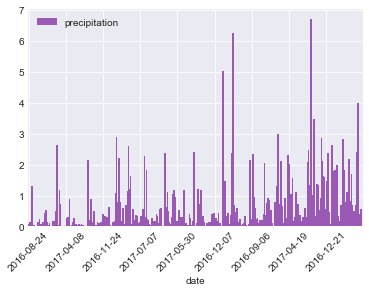

In [12]:
plt.style.use('seaborn-darkgrid')
precipitation_df.plot(kind='bar', stacked=True, width=10,color="#9b59b6")
label_x = [precipitation_df.index.values[i] for i in range(0, len(precipitation_df.loc[:,["precipitation"]]), 225)]
plt.xticks(np.arange(0, len(precipitation_df.loc[:,["precipitation"]]), 225),label_x,rotation=45)

plt.show()

In [13]:
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
total_station = session.query(func.count(Station.name))[0][0]
print(f"Total number of stations is {total_station}")

Total number of stations is 9


In [15]:
most_active_station = session.query(Measurement.station,func.count(Measurement.tobs)).\
                        group_by(Measurement.station).order_by(func.count(Measurement.tobs))[-1][0]
print(f"{most_active_station} station has the highest number of observations")

USC00519281 station has the highest number of observations


In [16]:
tobs_df = pd.read_sql(session.query(Measurement.tobs).\
                               filter(Measurement.date>last_12_month).\
                               filter(Measurement.station==most_active_station).\
                               statement, engine)
tobs_df.head()

,tobs
0,77
1,80
2,80
3,75
4,73


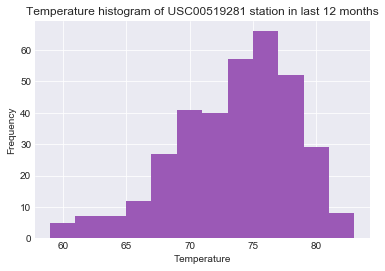

In [17]:
tobs_df.hist(bins=12,color="#9b59b6")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title(f"Temperature histogram of {most_active_station} station in last 12 months")
plt.show()

In [18]:
def calc_temps(start_date, end_date):
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date() + relativedelta(months=-12)
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d').date() + relativedelta(months=-12)
    tmin, tavg, tmax = session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).\
                               filter(Measurement.date>=start_date).\
                               filter(Measurement.date<=end_date).first()
    return tmin, tavg, tmax

In [19]:
tmin, tavg, tmax = calc_temps("2018-05-01", "2018-05-10")
print(tmin, tavg, tmax)

65 75.14285714285714 80


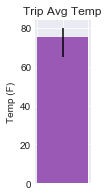

In [20]:
fig, ax = plt.subplots(figsize=(1,3))
x = np.arange(0, 1, 1)
y = tavg
lower_error = 0 * x + tavg - tmin
upper_error = 0 * x + tmax - tavg
asymmetric_error = [lower_error, upper_error]
plt.bar(x, y, yerr=asymmetric_error,width=1,color="#9b59b6")
labels = [item.get_text() for item in ax.get_xticklabels()]
empty_string_labels = ['']*len(labels)
ax.set_xticklabels(empty_string_labels)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.show()

In [21]:
#the rainfall per weather station
def calc_rainfall(date):
    last_year_date = datetime.datetime.strptime(date, '%Y-%m-%d').date() + relativedelta(months=-12)
    results = session.query(Measurement.station, Measurement.prcp).\
                               filter(Measurement.date==last_year_date).group_by(Measurement.station).all()
    print(f"Rainfall per weather station for {date} is:")
    for result in results:
        print(f"Station: {result[0]}, Rainfall: {result[1]}")

In [22]:
calc_rainfall("2018-05-01")

Rainfall per weather station for 2018-05-01 is:
Station: USC00513117, Rainfall: 0.07
Station: USC00514830, Rainfall: 0.03
Station: USC00516128, Rainfall: 0.25
Station: USC00519281, Rainfall: 0.13
Station: USC00519397, Rainfall: 0.26
Station: USC00519523, Rainfall: 0.07


In [25]:
def daily_normals(trip_date):
    trip_date = "%"+trip_date
    tmin, tavg, tmax = session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).filter(Measurement.date.like(trip_date)).first()
    return tmin, tavg, tmax

In [28]:
trip_date_list = ["05-01","05-02","05-03","05-04","05-05"]

In [29]:
daily_normals_list = []

for trip_date in trip_date_list:
    tmin,tavg,tmax = daily_normals(trip_date)
    daily_normals_dict = {}
    daily_normals_dict["tmin"] = tmin
    daily_normals_dict["tavg"] = tavg
    daily_normals_dict["tmax"] = tmax
    daily_normals_list.append(daily_normals_dict)
daily_normals_list

[{'tavg': 72.75925925925925, 'tmax': 79, 'tmin': 65},
 {'tavg': 73.09433962264151, 'tmax': 79, 'tmin': 65},
 {'tavg': 73.28846153846153, 'tmax': 84, 'tmin': 67},
 {'tavg': 73.47169811320755, 'tmax': 78, 'tmin': 65},
 {'tavg': 73.2, 'tmax': 79, 'tmin': 67}]

In [30]:
trip_date_year_list = []
for trip_date in trip_date_list:
    trip_date_year_list.append("2018-"+trip_date)
trip_date_year_list

['2018-05-01', '2018-05-02', '2018-05-03', '2018-05-04', '2018-05-05']

In [31]:
daily_normals_df = pd.DataFrame(daily_normals_list,index=trip_date_year_list,columns=["tmin","tavg","tmax"])

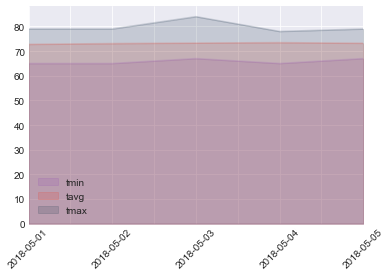

In [32]:
daily_normals_df.plot.area(alpha=0.2,color=["#9b59b6", "#e74c3c", "#34495e"],stacked=False)
plt.xticks(rotation=45)
plt.show()